In [1]:
# Swan = False
# if Swan == True:
%run Utils.py

Running Utilis


In [2]:
%matplotlib widget
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm
from matplotlib.ticker import LogFormatter 
from Utils import *
from scipy.optimize import curve_fit
import copy
import os
import h5py
import json

import PyPDF2                       # Per unire i PDF alla fine
import glob                         # Per manipolazione dei path

from collections.abc import Iterable


Running Utilis


In [3]:
config_file = r"./config.json"
print(config_file)

with open(config_file, "r") as f:
            dizi = json.load(f)
        
dizi
print('offset_y2 ', dizi['offset_y2'])
print('offset_x2 ', dizi['offset_x2'])
Swan = False

./config.json
offset_y2  0.12919836895267223
offset_x2  -0.35276844772093113


<KeysViewHDF5 ['Ievent', 'digi_base', 'digi_ph', 'digi_time', 'info_plus', 'nclu', 'nstrip', 'xinfo', 'xpos']>
offset_y2  0.12919836895267223
offset_x2  -0.35276844772093113
2.541
2.411801631047328


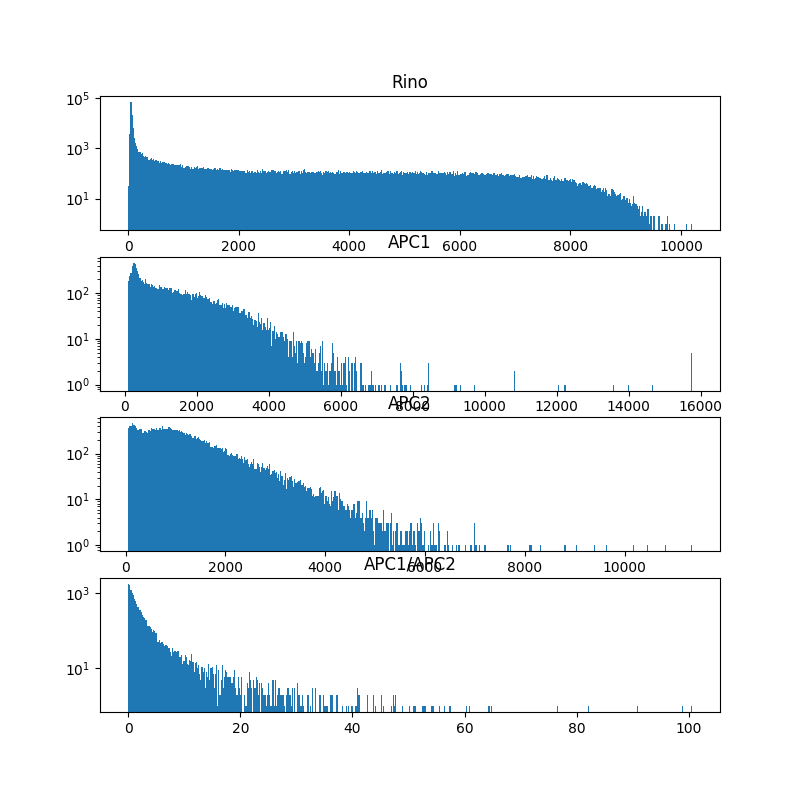

In [4]:
n_runs = [550238]

fig, ax = plt.subplots(4)
fig.set_size_inches(8,8)
En_values     = []
sigma_values  = []
peak_values = []
for i, run in enumerate(n_runs):
    # print(str(Beam_en[i])+' GeV')
   xpos,xinfo,ph,tm,evi,Rino1,Rino2,APC1,APC2,x1,y1,x2,y2,x_cry,y_cry = file_corrector(run)

# ax[0].hist(Rino1[Rino1>200],500)
ax[0].hist(Rino1,500)
# ax[0].hist(Rino2,50)
ax[0].set_title('Rino')
ax[0].set_yscale('log')
ax[1].hist(APC1[APC1>100],500)
ax[1].set_title('APC1')
ax[1].set_yscale('log')
ax[2].hist(APC2[APC2>50],500)
ax[2].set_title('APC2')
ax[2].set_yscale('log')
result = [a / b if b != 0 else 0 for a, b in zip(APC1[APC1>100], APC2[APC2>50])]
ax[3].hist(result,500)
ax[3].set_title('APC1/APC2')
ax[3].set_yscale('log')

plt.show()


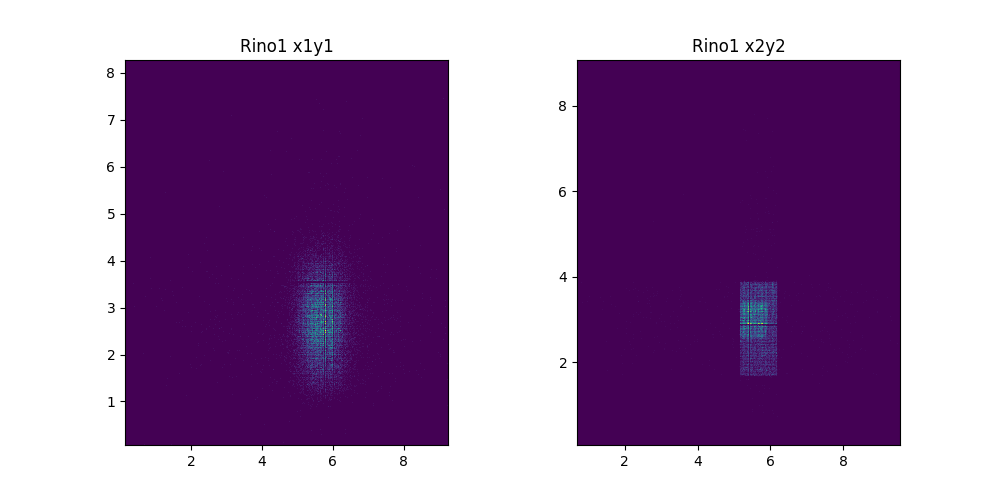

In [10]:
num_bins = 500
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
fig.subplots_adjust(wspace=.4,hspace=.8)

ax=ax.flatten()

# logi = (APC2>50) & (APC2<6000)
titles = ['APC2 x1y1','APC2 x2y2']
logi = (Rino1>200)
titles = ['Rino1 x1y1','Rino1 x2y2']

x1 = xpos[:,1]
y1 = xpos[:,0]
x2 = xpos[:,3]
y2 = xpos[:,2]


ax[0].hist2d(x1[logi],y1[logi], bins=num_bins)
ax[1].hist2d(x2[logi],y2[logi], bins=num_bins)

for i in range(2):
    ax[i].set_title(titles[i])
  

plt.show()

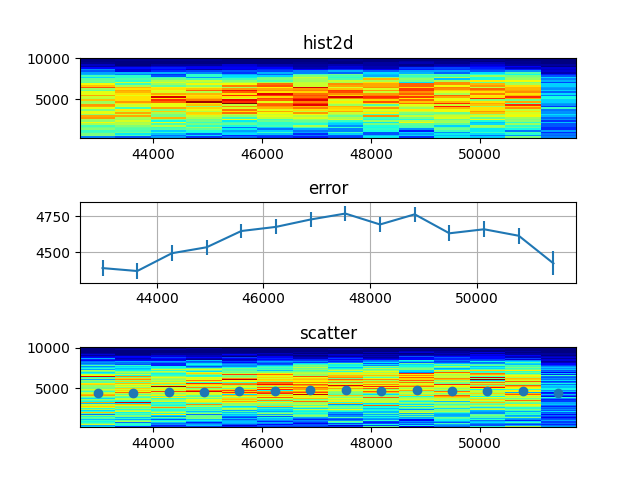

47559.890999999996


In [12]:
import succolib as suc

x2_range = [5.2,5.9]
y2_range = [2.6,3.36]
cmap = "jet"
logi_x = (x2 > x2_range[0]) & (x2 < x2_range[1]) 
logi_y = (y2 > y2_range[0]) & (y2 < y2_range[1]) 

logi_cry = logi_x & logi_y 
logiRino = Rino1>200
logiFin = logiRino & logi_cry #& logiRino
rot= xinfo[:,0]
crad= xinfo[:,1]

num_bins = 500

fig, ax = plt.subplots(3,1)
fig.subplots_adjust(wspace=.4,hspace=.8)
ax[0].set_title("hist2d")
ax[0].hist2d(rot[logiFin], Rino1[logiFin], bins=[14,50], cmap=cmap)


# fig.set_size_inches(10,5)
ax[1].set_title('error')
hh = plt.hist2d(rot[logiFin], Rino1[logiFin], bins=[14,100], cmap=cmap)
X_prof, Y_prof ,sigma_Y = suc.hist2dToProfile(hh, "mean")
ax[1].errorbar(X_prof,Y_prof,sigma_Y)
ax[1].grid()

ax[2].set_title('scatter')
ax[2].scatter(X_prof,Y_prof)


plt.show()

rotPeak=np.unique(rot)[np.argmax(Y_prof)]
print(rotPeak)

Rino vs rot
Rino vs rot+theta_x_in

idem apc

### Rino vs Rot


(3,)
0 [5.90597467e+03 2.35478825e-01 8.87557137e+02]
La divergenza in y vale 887.56 urad
1 [3127.45445445  -14.94594965 1601.32419767]
La divergenza in x vale 1601.32 urad


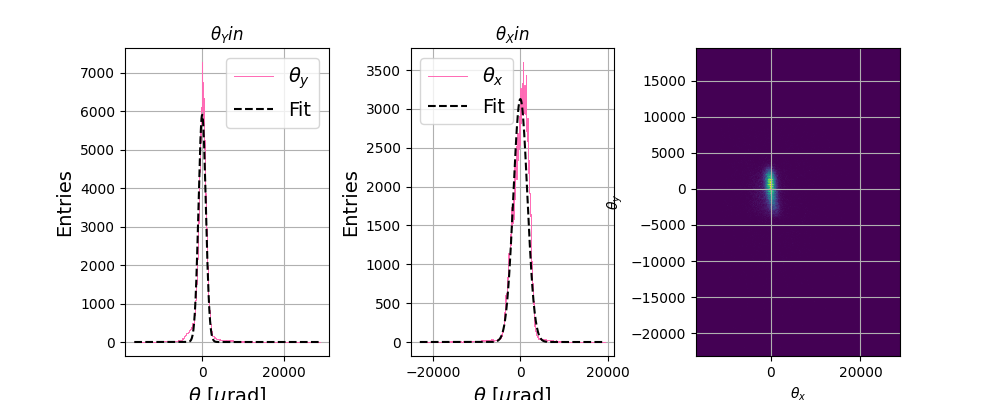

In [13]:
theta_in_x = np.arctan((x_cry-x1)/dizi['d_1c']) * 1e6 # urad
theta_in_y = np.arctan((y_cry-y1)/dizi['d_1c']) * 1e6 # urad

thetain = [theta_in_x, theta_in_y]

thetaLbl = ["y","x","_"]
num_bins = 500

fig, ax = plt.subplots(1,3)
fig.set_size_inches(10,4)
fig.subplots_adjust(wspace=.4,hspace=.8)
ax=ax.flatten()
print(ax.shape)
# titles = [fr"$\theta_X in$ ", fr"$\theta_Y in $","_"]
titles = [ fr"$\theta_Y in $",fr"$\theta_X in$ ","_"]
fit_par=[]
for i in range(2):
    h, bins = np.histogram(thetain[i], bins = 500)
    binc = bins[:-1] + (bins[1] - bins[0]) / 2

    p0 = (np.max(h), binc[np.argmax(h)], np.std(thetain[i]))
    cond = h>0
    popt, pcov = curve_fit(myGauss, binc[cond], h[cond], sigma = np.sqrt(h[cond]), absolute_sigma = True, p0 = p0)
    fit_par.append(popt)
    print (i, popt)
    ax[i].plot(binc, h, ds = "steps-mid", c = "hotpink", lw = .7,
               label = fr"$\theta_{thetaLbl[i]}$")
    
    ax[i].plot(binc, myGauss(binc, *popt), ls = "--", c = "k", label = f"Fit")# ({popt[1]:.2f} $\pm$ {popt[2]:.2f} mrad)")
    
    ax[i].grid()
    ax[i].set_title(titles[i])
    ax[i].set_ylabel("Entries", fontsize = 14)    
    ax[i].set_xlabel(r"$\theta$ [$\mu$rad]",fontsize = 14)
    
    ax[i].legend(fontsize = 14)
    
    print(f"La divergenza in {thetaLbl[i]} vale {popt[2]:.2f} urad")


# Creazione del plot
ax[2].hist2d(thetain[0], thetain[1], bins=num_bins)

# for a in ax: 
#     a.set_xlim((-4000,+3000))

# Etichette degli assi
ax[2].grid()
ax[2].set_xlabel(r"$\theta_x$ ")
ax[2].set_ylabel(r"$\theta_y$ ")
# ax[2].set_ylim((-4000,+3000))
plt.show()

In [14]:
print(fit_par[1][1])
theta_x_in=fit_par[1][1]

-14.94594964850272


158432


/var/folders/ds/clcsgq710m905vq5y0gwr98w0000gn/T/ipykernel_20833/3311735760.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(3,1)


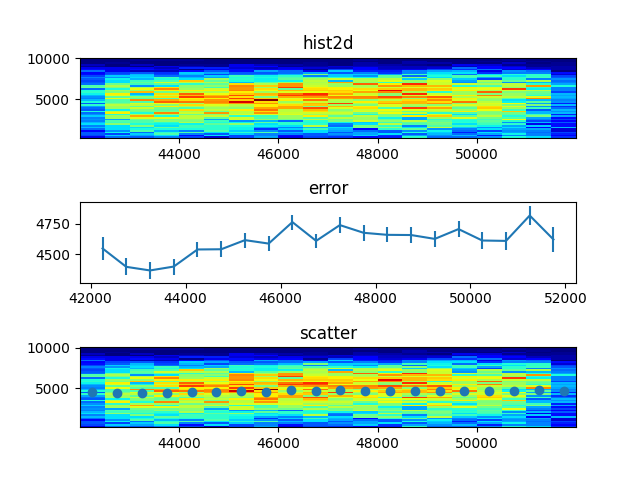

42658.793


In [26]:
import succolib as suc

div_range = [42000,52000]

logi_x = (x2 > x2_range[0]) & (x2 < x2_range[1]) 
logi_y = (y2 > y2_range[0]) & (y2 < y2_range[1]) 

logi_cry = logi_x & logi_y 
logiRino = (Rino1>200)

rot_div= xinfo[:,0] + theta_in_x
logiAng= (rot_div > div_range[0]) & (rot_div<div_range[1])

logiFinal = logiRino &logi_cry & logiAng #
# rot_div= [el + theta_in_x for el in xinfo[:,0][Rino1<200]]
crad= xinfo[:,1]
print(len(rot))

num_bins = 500

fig, ax = plt.subplots(3,1)
fig.subplots_adjust(wspace=.4,hspace=.8)
ax[0].set_title("hist2d")
# ax[0].hist2d(rot, Rino1[Rino1<200], bins=[27,100])
ax[0].hist2d(rot_div[logiFinal], Rino1[logiFinal], bins=[20,50], cmap=cmap)


# fig.set_size_inches(10,5)
ax[1].set_title('error')
hh = plt.hist2d(rot_div[logiFinal], Rino1[logiFinal], bins=[20,50], cmap=cmap)
X_prof, Y_prof ,sigma_Y = suc.hist2dToProfile(hh, "mean")
ax[1].errorbar(X_prof,Y_prof,sigma_Y)

ax[2].set_title('scatter')
ax[2].scatter(X_prof,Y_prof)


plt.show()

rotPeak=rot[np.argmax(Y_prof)]
print(rotPeak)

In [43]:
rot_values = hh[1]
y_list = hh[2]
z = hh[0]

print(x_list.shape[0], y_list.shape[0], z.shape[0]) 
#print(z)

DictHist={}
for i, angle in enumerate(rot_values):
    DictHist[str(angle)]=z[i].tolist()

print(DictHist)

21 51 20


IndexError: index 20 is out of bounds for axis 0 with size 20